[View in Colaboratory](https://colab.research.google.com/github/oishiikurigohan/AccelerometerMonitor/blob/master/test.ipynb)

#Google Colabの環境確認

In [40]:
!cat /etc/issue
!df -h
#!pip freeze
#!cat /proc/cpuinfo
#!cat /proc/driver/nvidia/gpus/0000:00:04.0/information

Ubuntu 17.10 \n \l

Filesystem      Size  Used Avail Use% Mounted on
overlay         359G  7.6G  333G   3% /
tmpfs           6.4G     0  6.4G   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
tmpfs           6.4G  249M  6.2G   4% /opt/bin
/dev/sda1       365G  9.7G  356G   3% /etc/hosts
shm              64M     0   64M   0% /dev/shm
tmpfs           6.4G     0  6.4G   0% /sys/firmware


#TensorflowがGPUを認識しているか確認
device_type: "GPU" の表示があればOKです。

In [41]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1311297832535613279, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11281989632
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9759993688664087823
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

# ngrokのインストール
Google ColabでTensorBoardを利用するために、ローカルPCとの接続をトンネリングするツールをインストールします。

In [42]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


Redirecting output to ‘wget-log.2’.
Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


# TensorBoardをバックグラウンドで実行

In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

# ngrokバックグラウンドプロセスを起動
TensorBoardのポート6006を開放します。

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

# TensorBoardのURLを取得

In [45]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://33327919.ngrok.io


# KerasのCNNモデルを実行

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 9216)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_28 (Dropout)         (None, 128)               0         
__________

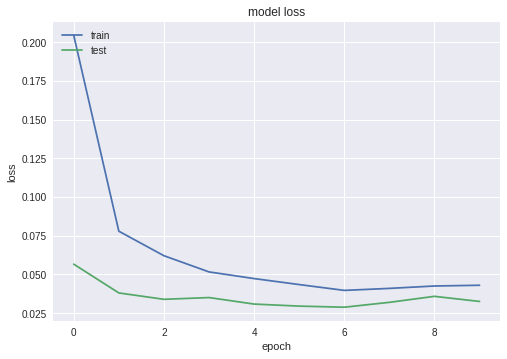

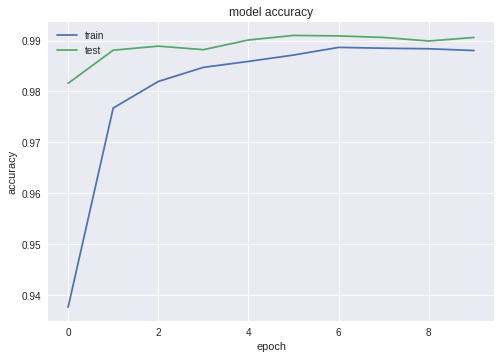

In [46]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 10
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# データのフォーマットを確認
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# [0-255]の値を[0.0-1.0]に変換
x_train = x_train.astype('float32') / 255 
x_test = x_test.astype('float32') / 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# 畳み込みニューラルネットワークを構築
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=num_classes, activation='softmax'))

# モデルの要約を表示
model.summary()

# モデルのコンパイル
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

# 訓練中に適応するコールバックを作成
callback = keras.callbacks.TensorBoard(log_dir='./log', histogram_freq=0)

# モデルの訓練と評価
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[callback])


# 損失値と正解率を取得
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# 損失値をグラフ表示
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 正解率をグラフ表示
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()